In [5]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [6]:
transform = transforms.ToTensor() # definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)  # carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  # cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)  # carrega a parte de validação
valloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  # cria um buffer para pegar os dados por partes

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST\raw



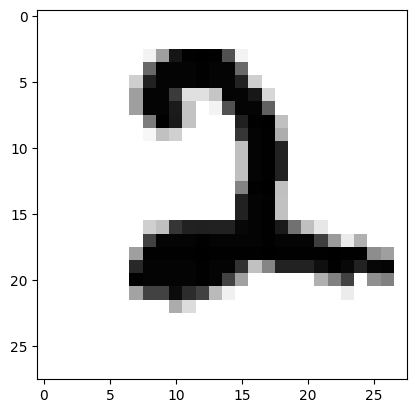

In [20]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap="gray_r")

In [10]:
print(imagens[0].shape)  # verificando as dimensões do tensor de cada imagem
print(etiquetas[0].shape)  # verificando as dimensões do tensor de cada estiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [11]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128)  # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64)  # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10)  # camada interna 2, 64 neurônios que se ligam a 10

        # para a camada de saida não é necessário definir nada pois só é preciso pegar o output da camada interna2

    def forward(self, X):
        X = F.relu(self.linear1(X))  # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X))  # função de ativação de camada interna 1 para camada interna 2
        X = self.linear3(X)  # função de ativação de camada interna 2 para a camada de saida, nesse caso f(x) = x
        return F.log_softmax(X, dim=1)  # dados utilizados para calcular a perda

In [12]:
def treino(modelo, trainloader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a politica de atualização dos pesos e bias
    inicio = time()  # timer para saber quanto tempo levou o treino

    criterio = nn.NLLLoss()  # definindo o criterio para calcular a perda
    EPOCHS = 10  # numero de epochs que o algoritimo rodará
    modelo.train()  # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0  # inicialização da perda acumulada da epoch em questão

        for imagens, etiquetas in trainloader:
            imagens = imagens.view(imagens.shape[0], -1)  # convertendo as imagens para "vetores" de 28*28 para ficarem compativeis
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device))  # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device))  # calculando a perda da epoch em questão 

            perda_instantanea.backward()  # back propagation a partir da perda

            otimizador.step()  # atualizando os pesos e a bias

            perda_acumulada += perda_instantanea.item()  # atualização da perda acumulada

        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) = ",(time()-inicio)/60)

In [13]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device))  # output do modelo em escala logaritmica

            ps = torch.exp(logps)  # converte output para escala normal
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab))  # converte o tensor em um numero
            etiqueta_certa = etiquetas.numpy()[i]
            if(etiqueta_certa == etiqueta_pred):  # compara a previsão com valor correto
                conta_corretas += 1
            conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão de modelo = {}%".format(conta_corretas*100/conta_todas))

In [14]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)